 Xây dựng hàm get_model() linh hoạt, hỗ trợ 10 kiến trúc SOTA: SimpleCNN, AlexNet, MobileNetV2/V3, ResNet18/50, ShuffleNetV2, DenseNet121, EfficientNetV2 và ConvNeXt_Tiny.

In [9]:
import os, hashlib, shutil, random, cv2, torch, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support, mean_squared_error, r2_score
from tqdm import tqdm

# Cấu hình hệ thống
BASE_PATH = r'd:\HUTECH\AI\DeepLearning\DAHS\MangoLeaf'
DST_PATH = os.path.join(BASE_PATH, 'dataset_scientific_split')
RESULT_PATH = os.path.join(BASE_PATH, 'Result')
IMG_SIZE = 224; BATCH_SIZE = 32; EPOCHS = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder(os.path.join(DST_PATH, 'train'), transform=transform)
val_set = datasets.ImageFolder(os.path.join(DST_PATH, 'val'), transform=transform)
test_set = datasets.ImageFolder(os.path.join(DST_PATH, 'test'), transform=transform)

# Tối ưu nạp dữ liệu
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

CLASS_NAMES = train_set.classes; NUM_CLASSES = len(CLASS_NAMES)
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'   [EarlyStopping] Counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


def get_model(name, num_classes):
    if name == 'SimpleCNN': m = nn.Sequential(
            # Khối 1: Trích xuất đặc trưng thấp
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 224 -> 112
            
            # Khối 2: Trích xuất đặc trưng trung bình
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 112 -> 56
            
            # Khối 3: Trích xuất đặc trưng cao
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 56 -> 28
            
            # Global Average Pooling thay cho Flatten
            nn.AdaptiveAvgPool2d((1, 1)), # 128x28x28 -> 128x1x1
            nn.Flatten(),
            
            # Lớp phân loại tinh gọn
            nn.Linear(128, num_classes)
        )
    elif name == 'AlexNet':
        m = models.alexnet(weights='DEFAULT')
        # Thay thế classifier cũ bằng cấu trúc chống Overfitting
        m.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 1024), # Giảm từ 4096 xuống 1024 để bớt nặng
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )
    elif name == 'MobileNetV2':
        m = models.mobilenet_v2(weights='DEFAULT')
        # MobileNetV2 dùng m.classifier[1] làm lớp đầu ra
        m.classifier = nn.Sequential(
            nn.Dropout(p=0.4), # Tăng cường Dropout chống học vẹt
            nn.Linear(1280, num_classes) # Giữ nguyên đầu vào 1280 từ đặc trưng của MobileNet
        )
    elif name == 'MobileNetV3':
        m = models.mobilenet_v3_small(weights='DEFAULT')
        # m.classifier[3] là lớp Linear cuối cùng (1024 -> 1000)
        in_features = m.classifier[3].in_features
        m.classifier[3] = nn.Linear(in_features, num_classes)
    elif name == 'ResNet18':
        m = models.resnet18(weights='DEFAULT')
        num_ftrs = m.fc.in_features
        # Thay thế fc cũ bằng một Sequential để chống Overfitting
        m.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    elif name == 'ResNet50':
        m = models.resnet50(weights='DEFAULT')
        num_ftrs = m.fc.in_features # 2048
        m.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    elif name == 'ShuffleNetV2':
        m = models.shufflenet_v2_x1_0(weights='DEFAULT')
        # m.fc là lớp Linear(1024, num_classes) mặc định
        num_ftrs = m.fc.in_features # 1024
        m.fc = nn.Sequential(
            nn.Dropout(0.4), # Chống học vẹt bằng cách ngắt ngẫu nhiên 40% kết nối
            nn.Linear(num_ftrs, num_classes)
        )
    elif name == 'DenseNet121':
        m = models.densenet121(weights='DEFAULT')
        num_ftrs = m.classifier.in_features # 1024
        # Thay thế classifier bằng Sequential để chống Overfitting
        m.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_ftrs, num_classes)
    )
    elif name == 'EfficientNetV2':
        m = models.efficientnet_v2_s(weights='DEFAULT')
        # m.classifier[1] là lớp Linear cuối cùng (1280 -> 1000)
        num_ftrs = m.classifier[1].in_features # 1280
        m.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(num_ftrs, num_classes)
        )
    elif name == 'ConvNeXt_Tiny':
        m = models.convnext_tiny(weights='DEFAULT')
        # ConvNeXt dùng m.classifier[2] làm lớp Linear cuối cùng (768 -> 1000)
        in_features = m.classifier[2].in_features # 768
        m.classifier[2] = nn.Sequential(
            nn.Dropout(p=0.3), # Giảm nhẹ Dropout vì ConvNeXt đã có stochastic depth
            nn.Linear(in_features, num_classes)
        )
    return m.to(DEVICE)


### Mô hình: SimpleCNN
**Mô tả:** Baseline 2 lớp Conv.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\341333221.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


--- Đang khởi tạo mô hình: SimpleCNN với cấu trúc GAP chống học vẹt ---


Epoch 1/50 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\341333221.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Train]: 100%|██████████| 90/90 [00:14<00:00,  6.25it/s, loss=1.9806]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\341333221.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50/50 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.01it/s, loss=0.2151]


--- Đang đánh giá mô hình SimpleCNN trên tập Test ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\341333221.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(m_res_path, 'be

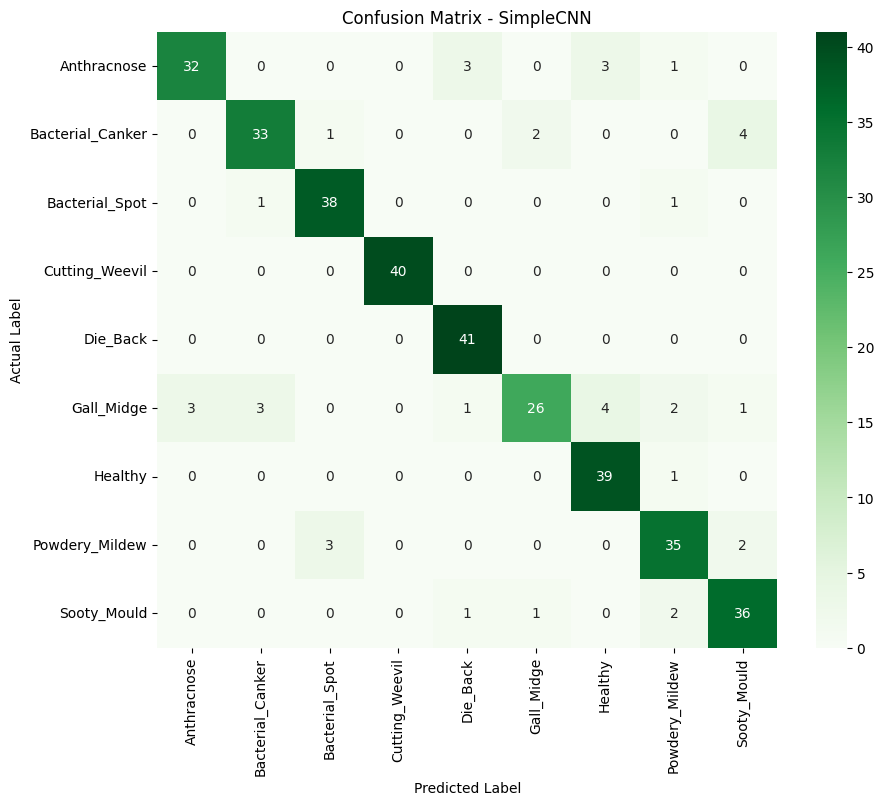

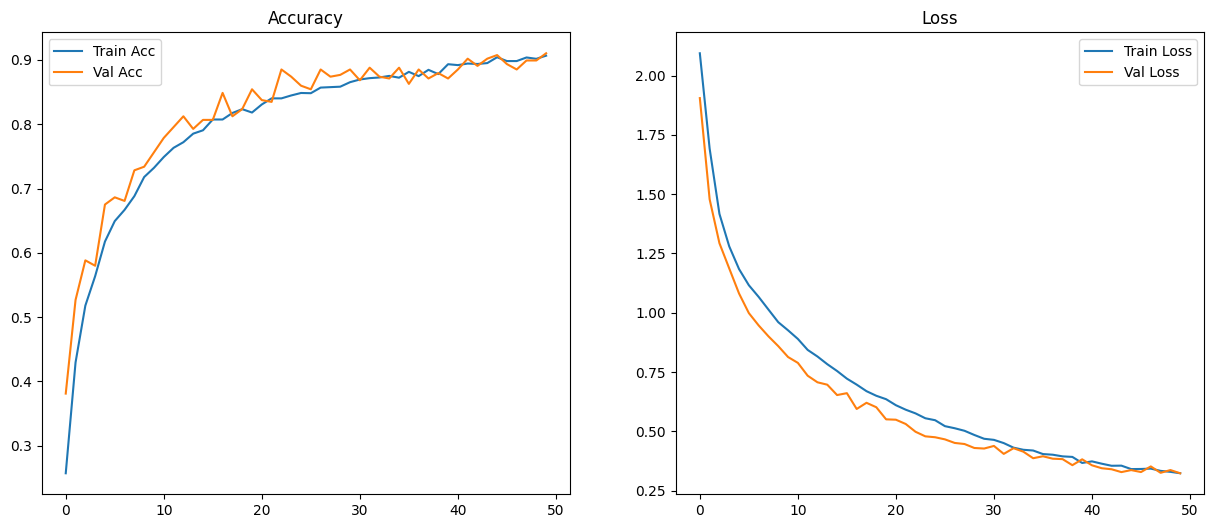

Done SimpleCNN: Test Accuracy=0.8889


In [10]:
## Huấn luyện TỐI ƯU mô hình: SimpleCNN
m_name = 'SimpleCNN'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} với cấu trúc GAP chống học vẹt ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopping(patience=8, verbose=True) # Dừng nếu 8 epoch không giảm loss

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

# --- VÒNG LẶP HUẤN LUYỆN ---
for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item(); _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item(); _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
    
    # Lưu lịch sử
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(v_correct/len(val_set))
    
    # Lưu mô hình tốt nhất
    if (v_correct/len(val_set)) > best_acc:
        best_acc = v_correct/len(val_set)
        torch.save(model.state_dict(), os.path.join(m_res_path, 'best_model.pth'))

# --- ĐÁNH GIÁ VÀ VẼ MA TRẬN NHẦM LẪN (Sau khi train xong) ---
print(f'--- Đang đánh giá mô hình {m_name} trên tập Test ---')
model.load_state_dict(torch.load(os.path.join(m_res_path, 'best_model.pth')))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# 1. Vẽ Ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix - {m_name}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(m_res_path, 'confusion_matrix.png'))
plt.show()

# 2. Tính toán các chỉ số phân loại
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)

# 3. Lưu báo cáo JSON (Không chứa MSE/RMSE)
with open(os.path.join(m_res_path, 'report.json'), 'w') as f:
    json.dump(report, f, indent=4)

# 4. Vẽ đồ thị Loss/Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc')
axes[0].set_title('Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title('Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png'))
plt.show()

print(f'Done {m_name}: Test Accuracy={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: AlexNet
**Mô tả:** Cổ điển mạnh mẽ.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.  


--- Đang khởi tạo mô hình: AlexNet (Pretrained + Optimized Classifier) ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\3589287768.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\3589287768.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Train]: 100%|██████████| 90/90 [00:14<00:00,  6.30it/s, loss=0.7182]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\3589287768.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50/50 [Train]: 100%|██████████| 90/90 [00:13<00:00,  6.64it/s, loss=0.0000]


--- Đang đánh giá AlexNet trên tập Test ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\3589287768.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(m_res_path, 'b

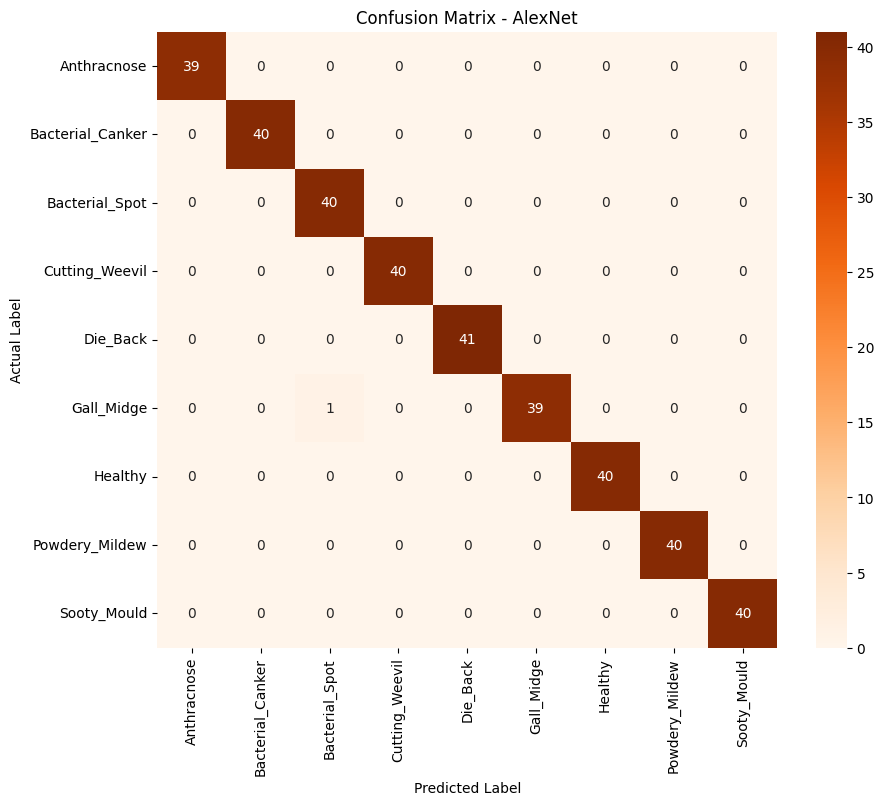

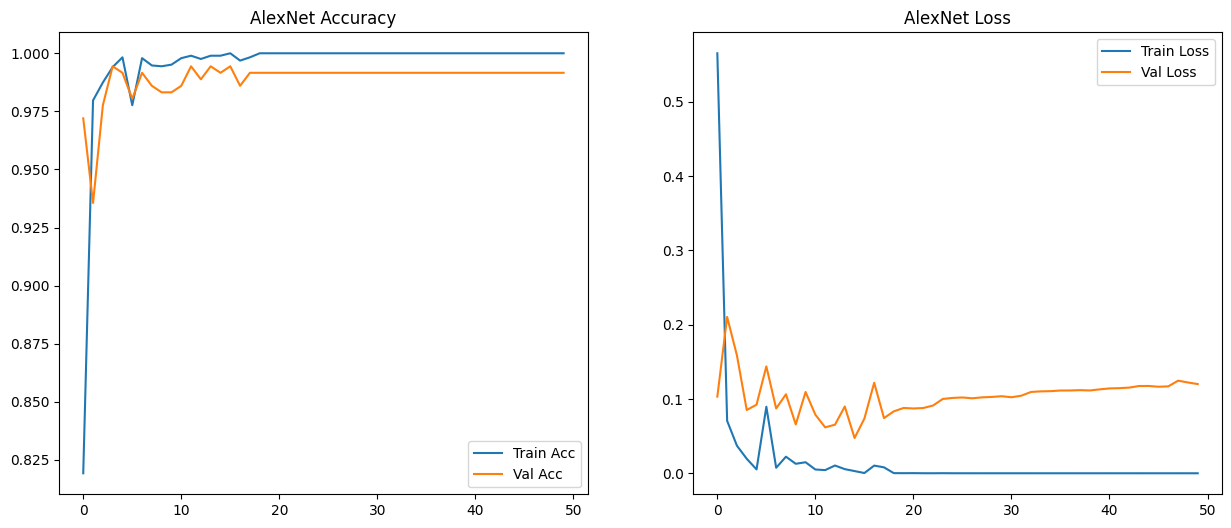

Done AlexNet: Best Val Accuracy=0.9944, Test Accuracy=0.9972


In [11]:
## Huấn luyện TỐI ƯU mô hình: AlexNet
m_name = 'AlexNet'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} (Pretrained + Optimized Classifier) ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopping(patience=8, verbose=True) # Dừng nếu 8 epoch không giảm loss

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(EPOCHS):
    # --- PHASE: TRAIN ---
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        tr_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # --- PHASE: VAL ---
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
    
    # Lưu lịch sử
    epoch_val_acc = v_correct / len(val_set)
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(epoch_val_acc)
    
    # Lưu model tốt nhất
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), os.path.join(m_res_path, 'best_model.pth'))

# --- ĐÁNH GIÁ VÀ VẼ MA TRẬN NHẦM LẪN ---
print(f'--- Đang đánh giá {m_name} trên tập Test ---')
model.load_state_dict(torch.load(os.path.join(m_res_path, 'best_model.pth')))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# 1. Vẽ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix - {m_name}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(m_res_path, 'confusion_matrix.png'))
plt.show()

# 2. Tính toán Metrics phân loại
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)

# 3. Lưu JSON Report (Đã loại bỏ MSE/RMSE)
with open(os.path.join(m_res_path, 'report.json'), 'w') as f:
    json.dump(report, f, indent=4)

# 4. Vẽ đồ thị Loss/Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc')
axes[0].set_title(f'{m_name} Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title(f'{m_name} Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png'))
plt.show()

print(f'Done {m_name}: Best Val Accuracy={best_acc:.4f}, Test Accuracy={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: MobileNetV2
**Mô tả:** Tối ưu di động.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\156365420.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


--- Đang khởi tạo mô hình: MobileNetV2 (Pretrained + Optimized) ---


Epoch 1/50 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\156365420.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Train]: 100%|██████████| 90/90 [00:21<00:00,  4.13it/s, loss=0.4103]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\156365420.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50/50 [Train]: 100%|██████████| 90/90 [00:20<00:00,  4.44it/s, loss=0.0007]


--- Đang đánh giá MobileNetV2 trên tập Test ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\156365420.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(m_res_path, 'be

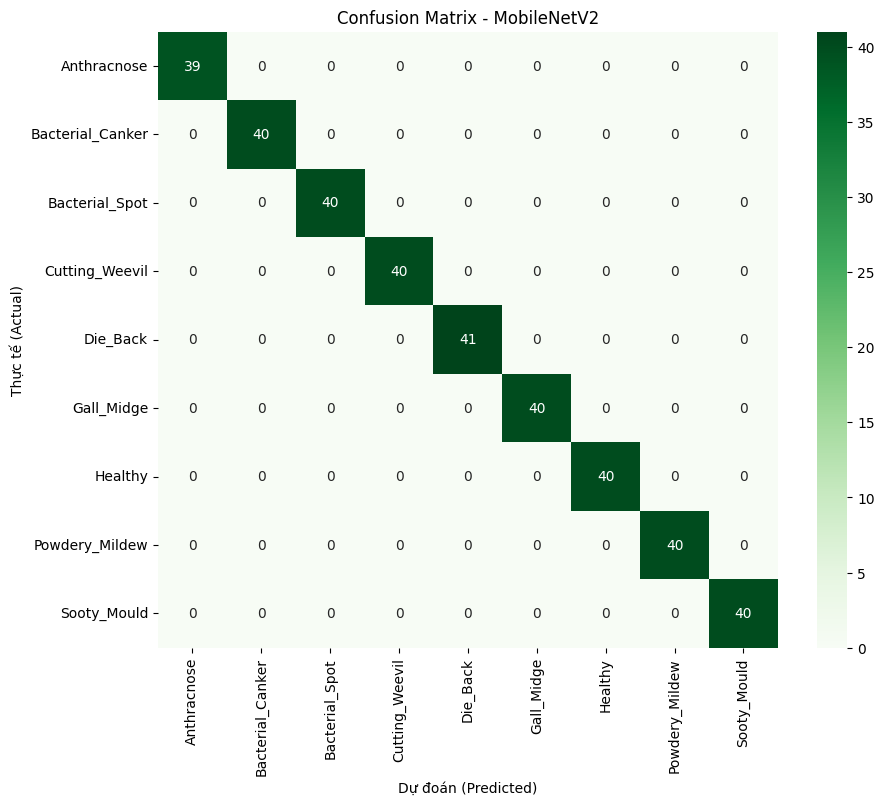

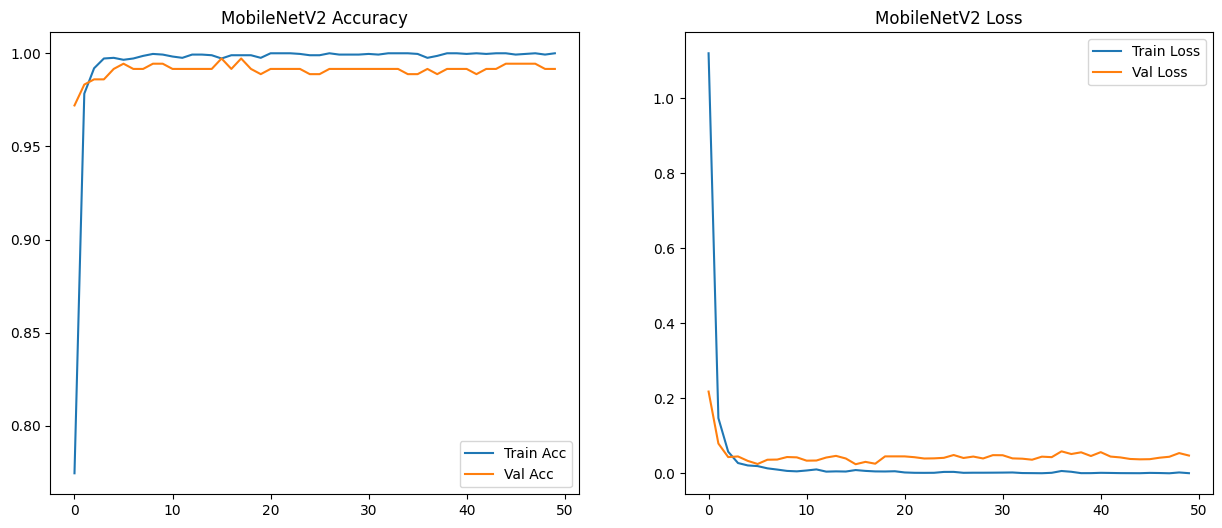

Done MobileNetV2: Best Val Acc=0.9972, Test Acc=1.0000


In [12]:
## Huấn luyện TỐI ƯU mô hình: MobileNetV2
m_name = 'MobileNetV2'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} (Pretrained + Optimized) ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) # Learning rate thấp giúp tinh chỉnh tốt hơn
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopping(patience=8, verbose=True) # Dừng nếu 8 epoch không giảm loss

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(EPOCHS):
    # --- PHASE: TRAIN ---
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        tr_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # --- PHASE: VAL ---
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
    
    # Tính toán & Lưu History
    epoch_val_acc = v_correct / len(val_set)
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(epoch_val_acc)
    
    # Lưu model tốt nhất (Checkpoint)
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), os.path.join(m_res_path, 'best_model.pth'))

# --- ĐÁNH GIÁ VÀ VẼ MA TRẬN NHẦM LẪN (Confusion Matrix) ---
print(f'--- Đang đánh giá {m_name} trên tập Test ---')
model.load_state_dict(torch.load(os.path.join(m_res_path, 'best_model.pth')))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# 1. Vẽ Ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix - {m_name}')
plt.ylabel('Thực tế (Actual)')
plt.xlabel('Dự đoán (Predicted)')
plt.savefig(os.path.join(m_res_path, 'confusion_matrix.png'))
plt.show()

# 2. Tính toán Metrics phân loại
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)

# 3. Lưu JSON Report (Sạch sẽ, không hồi quy)
with open(os.path.join(m_res_path, 'report.json'), 'w') as f:
    json.dump(report, f, indent=4)

# 4. Vẽ đồ thị Loss/Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc')
axes[0].set_title(f'{m_name} Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title(f'{m_name} Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png'))
plt.show()

print(f'Done {m_name}: Best Val Acc={best_acc:.4f}, Test Acc={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: MobileNetV3
**Mô tả:** Thế hệ MobileNet mới nhất.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\4078763110.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


--- Đang khởi tạo mô hình: MobileNetV3 (Optimized for Classification) ---


Epoch 1/50 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\4078763110.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Train]: 100%|██████████| 90/90 [00:15<00:00,  5.99it/s, loss=0.2075]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\4078763110.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50/50 [Train]: 100%|██████████| 90/90 [00:12<00:00,  7.45it/s, loss=0.0003]


--- Đang tạo ma trận nhầm lẫn cho MobileNetV3 ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\4078763110.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(m_res_path, 'b

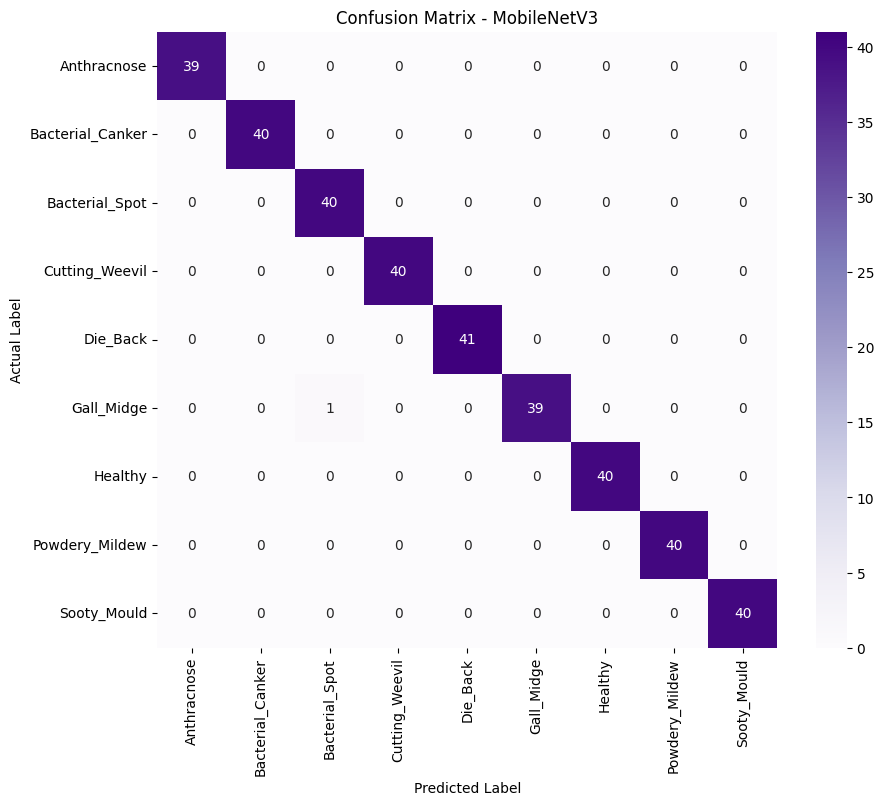

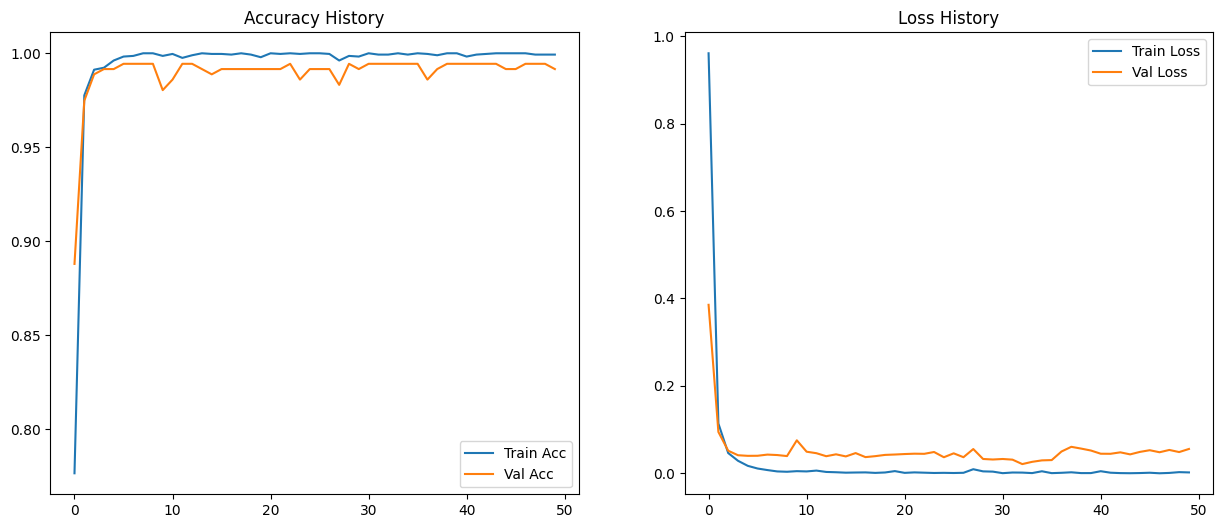

Done MobileNetV3: Best Val Acc=0.9944, Test Acc=0.9972


In [14]:
## Huấn luyện TỐI ƯU mô hình: MobileNetV3
m_name = 'MobileNetV3'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} (Optimized for Classification) ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopping(patience=5, verbose=True) # Dừng nếu 5 epoch không giảm loss

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(EPOCHS):
    # --- PHASE: TRAIN ---
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        tr_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # --- PHASE: VAL ---
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
    
    # Tính toán & Lưu History
    epoch_val_acc = v_correct / len(val_set)
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(epoch_val_acc)
    
    # Checkpoint model tốt nhất
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), os.path.join(m_res_path, 'best_model.pth'))

# --- ĐÁNH GIÁ SAU TRAIN (Tập Test) ---
print(f'--- Đang tạo ma trận nhầm lẫn cho {m_name} ---')
model.load_state_dict(torch.load(os.path.join(m_res_path, 'best_model.pth')))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# 1. Vẽ Confusion Matrix (Màu sắc mới cho MobileNetV3)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix - {m_name}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(m_res_path, 'confusion_matrix.png'))
plt.show()

# 2. Tính toán & Lưu Metrics
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
with open(os.path.join(m_res_path, 'report.json'), 'w') as f:
    json.dump(report, f, indent=4)

# 3. Vẽ đồ thị Loss/Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc')
axes[0].set_title('Accuracy History'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title('Loss History'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png'))
plt.show()

print(f'Done {m_name}: Best Val Acc={best_acc:.4f}, Test Acc={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: ResNet18
**Mô tả:** Residual depth 18.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\2115859545.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


--- Đang khởi tạo mô hình: ResNet18 (Residual Optimized) ---


Epoch 1/50 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\2115859545.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Train]: 100%|██████████| 90/90 [00:17<00:00,  5.29it/s, loss=0.1250]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\2115859545.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50/50 [Train]: 100%|██████████| 90/90 [00:16<00:00,  5.61it/s, loss=0.0333]


--- Đang đánh giá ResNet18 ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\2115859545.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(m_res_path, 'b

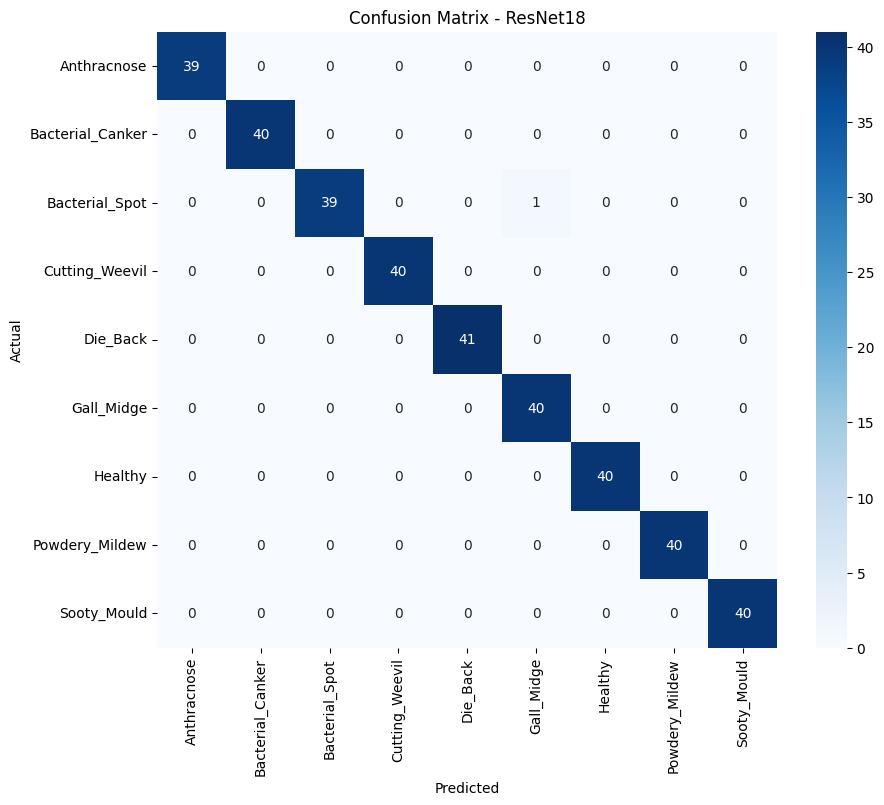

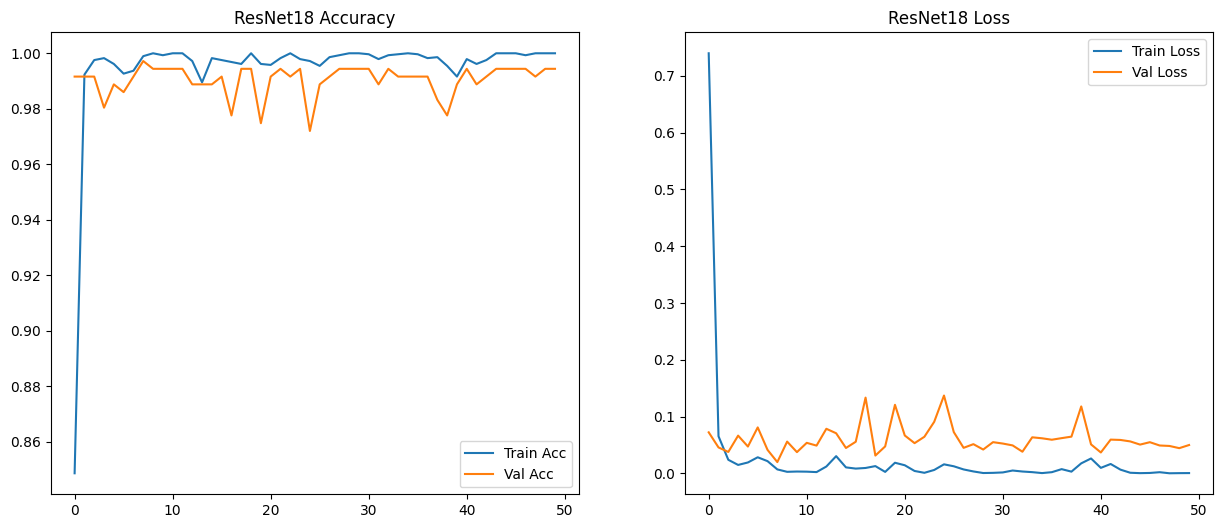

Done ResNet18: Best Val Acc=0.9972, Test Acc=0.9972


In [15]:
## Huấn luyện TỐI ƯU mô hình: ResNet18
m_name = 'ResNet18'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} (Residual Optimized) ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopping(patience=5, verbose=True) # Dừng nếu 5 epoch không giảm loss

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(EPOCHS):
    # --- PHASE: TRAIN ---
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        tr_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # --- PHASE: VAL ---
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in vbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
    
    # Tính toán & Lưu History
    epoch_val_acc = v_correct / len(val_set)
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(epoch_val_acc)
    
    # Lưu Checkpoint tốt nhất
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), os.path.join(m_res_path, 'best_model.pth'))

# --- ĐÁNH GIÁ CUỐI CÙNG (Tập Test) ---
print(f'--- Đang đánh giá {m_name} ---')
model.load_state_dict(torch.load(os.path.join(m_res_path, 'best_model.pth')))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# 1. Vẽ Ma trận nhầm lẫn (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix - {m_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(os.path.join(m_res_path, 'confusion_matrix.png'))
plt.show()

# 2. Lưu Báo cáo Phân loại (Sạch Metrics hồi quy)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
with open(os.path.join(m_res_path, 'report.json'), 'w') as f:
    json.dump(report, f, indent=4)

# 3. Vẽ đồ thị Loss/Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc')
axes[0].set_title(f'{m_name} Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title(f'{m_name} Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png'))
plt.show()

print(f'Done {m_name}: Best Val Acc={best_acc:.4f}, Test Acc={accuracy_score(y_true, y_pred):.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: ResNet50
**Mô tả:** Residual depth 50.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

--- Đang khởi tạo mô hình: ResNet50 (Bottleneck Optimized) ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\1795031568.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\1795031568.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Train]: 100%|██████████| 90/90 [00:27<00:00,  3.26it/s, loss=0.0072]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\1795031568.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50/50 [Train]: 100%|██████████| 90/90 [00:24<00:00,  3.62it/s, loss=0.1850]


--- Đang đánh giá ResNet50 trên tập Test ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\1795031568.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(m_res_path, 'b

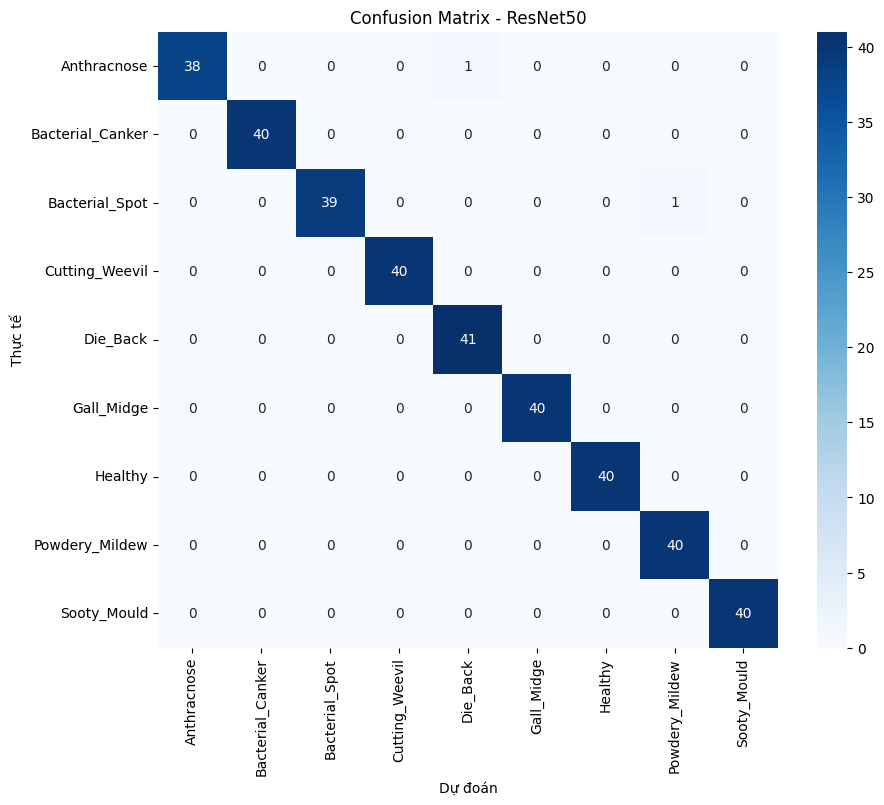

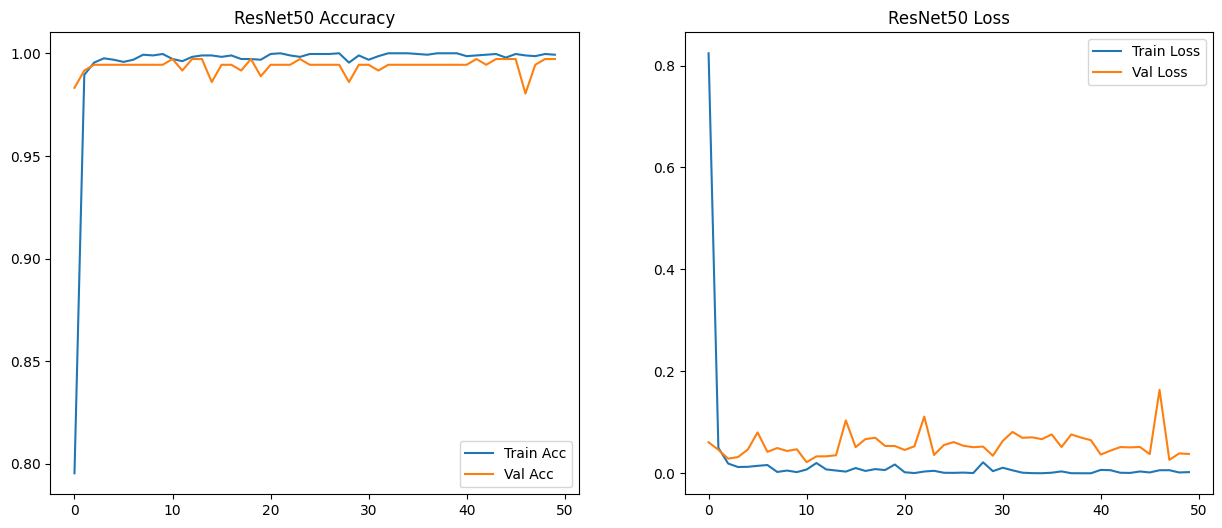

Done ResNet50: Best Val Acc=0.9972, Test Acc=0.9944


In [16]:
## Huấn luyện TỐI ƯU mô hình: ResNet50
m_name = 'ResNet50'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} (Bottleneck Optimized) ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopping(patience=5, verbose=True) # Dừng nếu 5 epoch không giảm loss 

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(EPOCHS):
    # --- PHASE: TRAIN ---
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        tr_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # --- PHASE: VAL ---
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
    
    # Lưu History
    epoch_val_acc = v_correct / len(val_set)
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(epoch_val_acc)
    
    # Lưu Checkpoint tốt nhất
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), os.path.join(m_res_path, 'best_model.pth'))

# --- ĐÁNH GIÁ VÀ VẼ MA TRẬN NHẦM LẪN ---
print(f'--- Đang đánh giá {m_name} trên tập Test ---')
model.load_state_dict(torch.load(os.path.join(m_res_path, 'best_model.pth')))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# 1. Vẽ Confusion Matrix (Dùng màu Blues đậm cho mô hình sâu)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix - {m_name}')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.savefig(os.path.join(m_res_path, 'confusion_matrix.png'))
plt.show()

# 2. Tính toán & Lưu Metrics phân loại (Xóa hồi quy)
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
with open(os.path.join(m_res_path, 'report.json'), 'w') as f:
    json.dump(report, f, indent=4)

# 3. Vẽ đồ thị Loss/Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc')
axes[0].set_title(f'{m_name} Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title(f'{m_name} Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png'))
plt.show()

print(f'Done {m_name}: Best Val Acc={best_acc:.4f}, Test Acc={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: ShuffleNetV2
**Mô tả:** Siêu nhẹ.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\2710295298.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


--- Đang khởi tạo mô hình: ShuffleNetV2 (Shuffle-Channel Optimized) ---


Epoch 1/50 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\2710295298.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\2710295298.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50/50 [Val]: 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\2710295298.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURI

--- Đang đánh giá ShuffleNetV2 trên tập Test ---


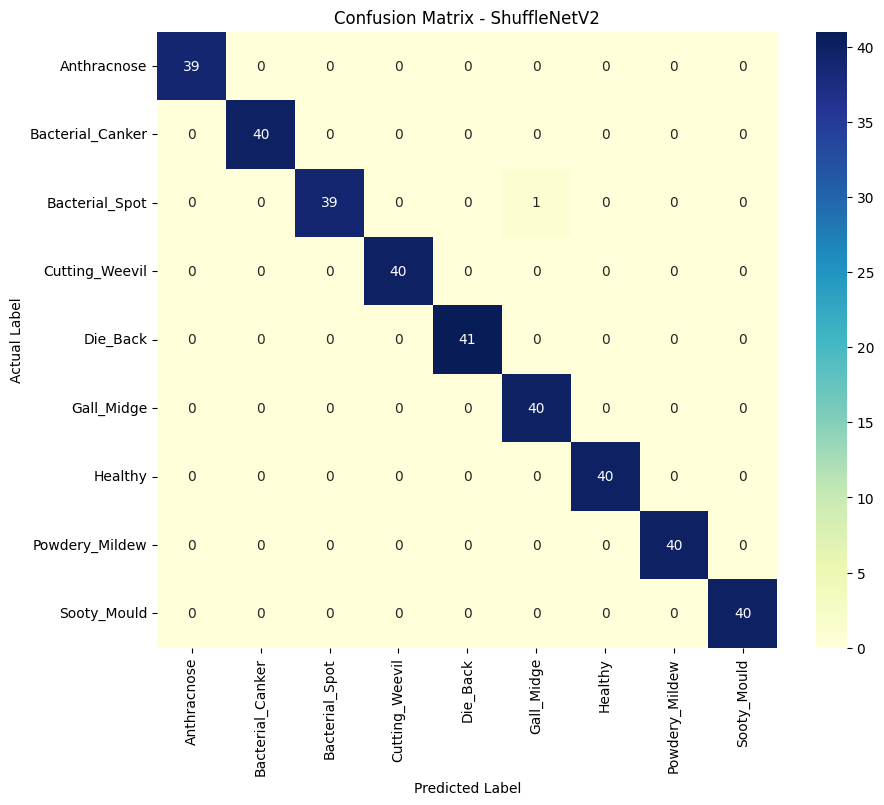

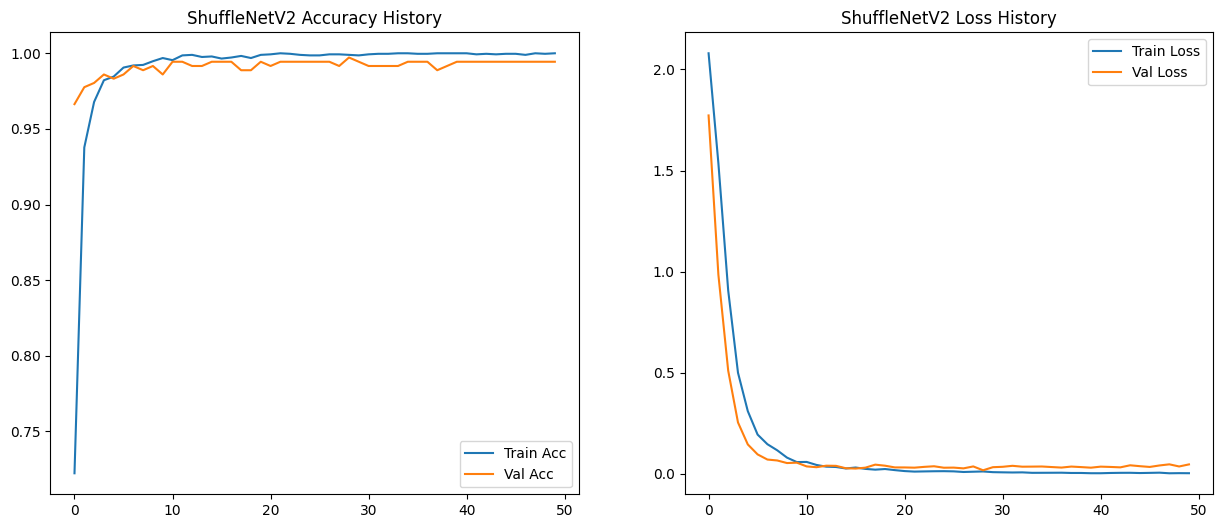

Done ShuffleNetV2: Best Val Acc=0.9972, Test Acc=0.9972


In [17]:
## Huấn luyện TỐI ƯU mô hình: ShuffleNetV2
m_name = 'ShuffleNetV2'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} (Shuffle-Channel Optimized) ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopping(patience=5, verbose=True) # Dừng nếu 5 epoch không giảm loss

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(EPOCHS):
    # --- PHASE: TRAIN ---
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        tr_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # --- PHASE: VAL ---
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        vbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Val]')
        for inputs, labels in vbar:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
    
    # Lưu History
    epoch_val_acc = v_correct / len(val_set)
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(epoch_val_acc)
    
    # Checkpoint: Lưu mô hình có Val Accuracy cao nhất
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), os.path.join(m_res_path, 'best_model.pth'))

# --- ĐÁNH GIÁ VÀ VẼ MA TRẬN NHẦM LẪN (Sau khi train) ---
print(f'--- Đang đánh giá {m_name} trên tập Test ---')
model.load_state_dict(torch.load(os.path.join(m_res_path, 'best_model.pth')))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# 1. Vẽ Ma trận nhầm lẫn (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix - {m_name}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(m_res_path, 'confusion_matrix.png'))
plt.show()

# 2. Tính toán & Lưu Báo cáo phân loại (Bỏ Metrics hồi quy)
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
with open(os.path.join(m_res_path, 'report.json'), 'w') as f:
    json.dump(report, f, indent=4)

# 3. Vẽ đồ thị Loss/Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc')
axes[0].set_title(f'{m_name} Accuracy History'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title(f'{m_name} Loss History'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png'))
plt.show()

print(f'Done {m_name}: Best Val Acc={best_acc:.4f}, Test Acc={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: DenseNet121
**Mô tả:** Kết nối dày đặc.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\2266922877.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


--- Đang khởi tạo mô hình: DenseNet121 (Dense-Connection Optimized) ---


Epoch 1/50 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\2266922877.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Train]: 100%|██████████| 90/90 [00:29<00:00,  3.06it/s, loss=0.1560]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\2266922877.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50/50 [Train]: 100%|██████████| 90/90 [00:26<00:00,  3.46it/s, loss=0.0057]


--- Đang đánh giá DenseNet121 ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\2266922877.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(m_res_path, 'b

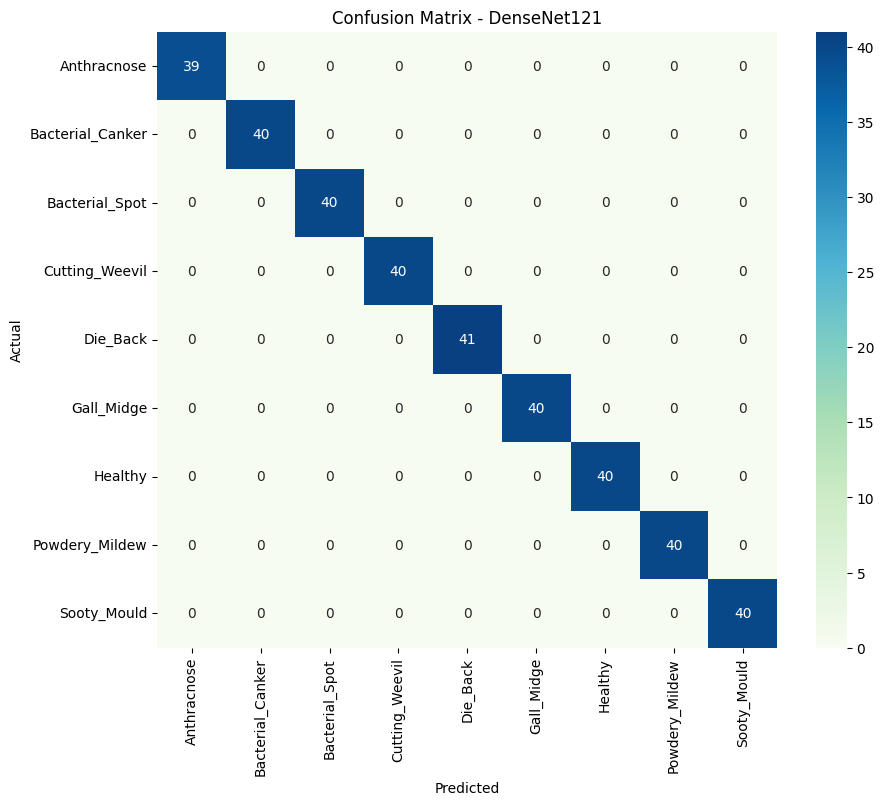

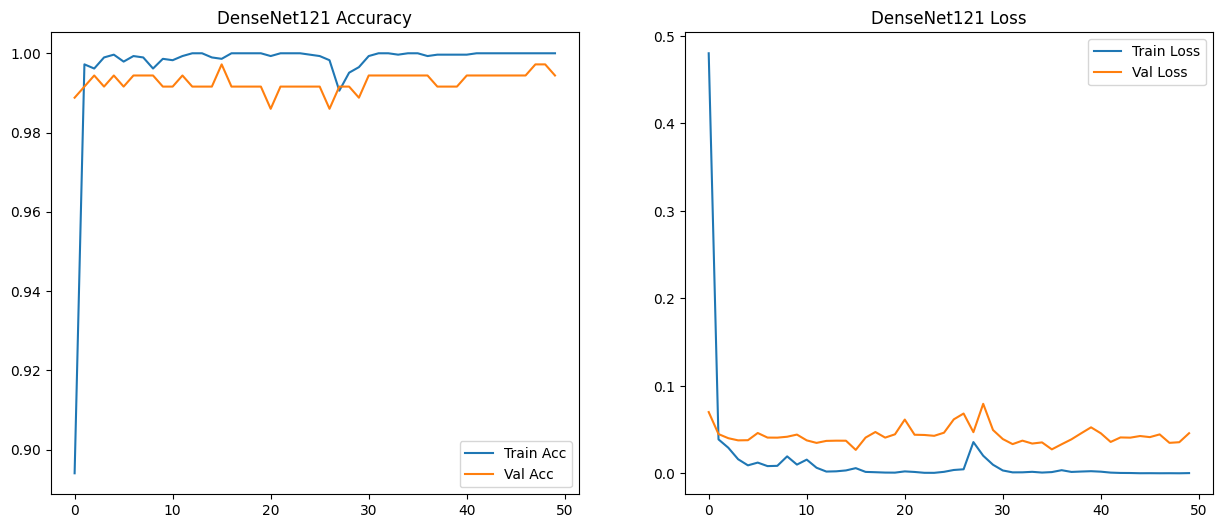

Done DenseNet121: Best Val Acc=0.9972, Test Acc=1.0000


In [18]:
## Huấn luyện TỐI ƯU mô hình: DenseNet121
m_name = 'DenseNet121'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} (Dense-Connection Optimized) ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopping(patience=5, verbose=True) # Dừng nếu 5 epoch không giảm loss

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(EPOCHS):
    # --- PHASE: TRAIN ---
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        tr_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # --- PHASE: VAL ---
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
    
    # Lưu History
    epoch_val_acc = v_correct / len(val_set)
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(epoch_val_acc)
    
    # Checkpoint tốt nhất
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), os.path.join(m_res_path, 'best_model.pth'))

# --- ĐÁNH GIÁ VÀ VẼ MA TRẬN NHẦM LẪN ---
print(f'--- Đang đánh giá {m_name} ---')
model.load_state_dict(torch.load(os.path.join(m_res_path, 'best_model.pth')))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# 1. Vẽ Confusion Matrix (Sử dụng bảng màu mát mắt Cyan/Blues)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix - {m_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(os.path.join(m_res_path, 'confusion_matrix.png'))
plt.show()

# 2. Tính toán & Lưu Báo cáo (Xóa metrics hồi quy)
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
with open(os.path.join(m_res_path, 'report.json'), 'w') as f:
    json.dump(report, f, indent=4)

# 3. Vẽ đồ thị Loss/Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc')
axes[0].set_title(f'{m_name} Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title(f'{m_name} Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png'))
plt.show()

print(f'Done {m_name}: Best Val Acc={best_acc:.4f}, Test Acc={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: EfficientNetV2
**Mô tả:** Tối ưu quy mô.

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

--- Đang khởi tạo mô hình: EfficientNetV2 (Speed Optimized) ---


Epoch 50/50: 100%|██████████| 90/90 [00:15<00:00,  5.77it/s]


--- Đang đánh giá EfficientNetV2 trên tập Test ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\4171349204.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(m_res_path, 'b

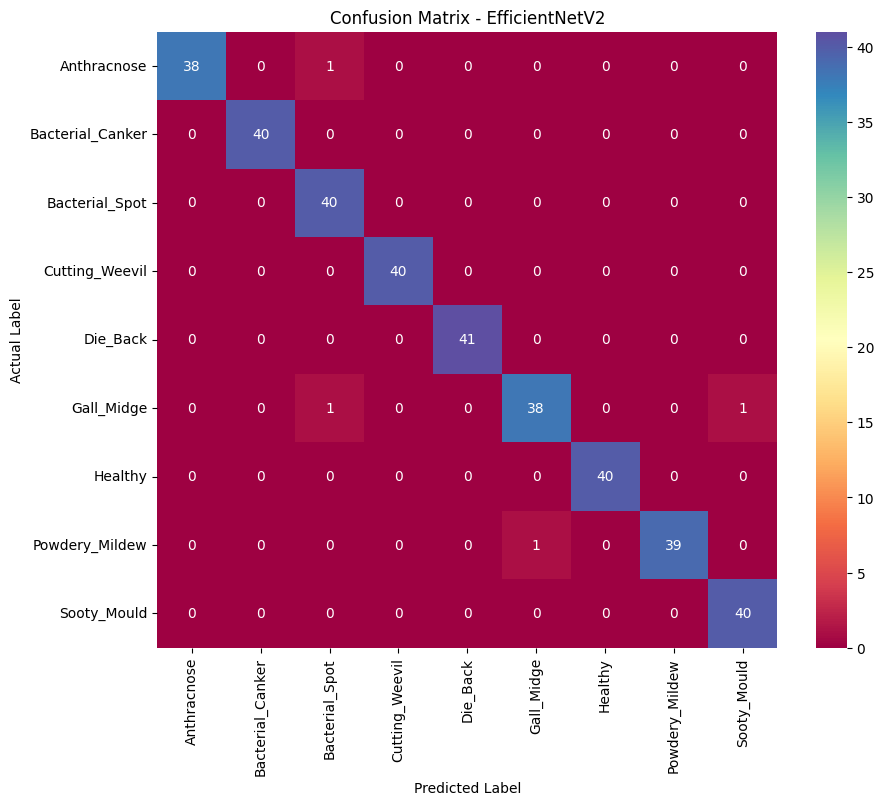

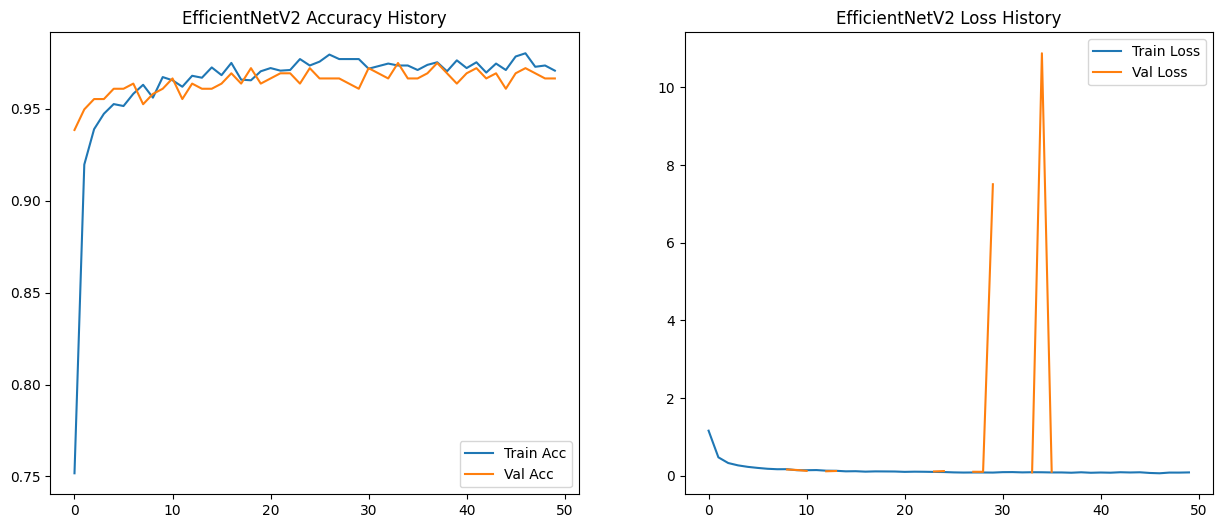

Done EfficientNetV2: Best Val Acc=0.9748, Test Acc=0.9889


In [21]:
## Huấn luyện TỐI ƯU mô hình: EfficientNetV2
m_name = 'EfficientNetV2'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} (Speed Optimized) ---')
model = get_model(m_name, NUM_CLASSES)

# TỐI ƯU 1: Đóng băng các lớp pretrained (Chỉ train lớp classifier mới)
# Điều này giúp giảm 70-80% khối lượng tính toán đạo hàm
for name, param in model.named_parameters():
    if "classifier" not in name: 
        param.requires_grad = False

# Chỉ nạp những tham số cần update vào Optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# TỐI ƯU 2: Sử dụng API AMP mới nhất (tránh cảnh báo)
scaler = torch.amp.GradScaler('cuda') 
early_stopper = EarlyStopping(patience=3, verbose=True) # Giảm patience để dừng sớm hơn nếu không hiệu quả

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(EPOCHS):
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True) # TỐI ƯU 3: Xóa gradient nhanh hơn
        
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        tr_loss += loss.item()
        tr_correct += (outputs.argmax(1) == labels).sum().item()
    
    # --- PHASE: VAL (Cực nhanh vì không tính đạo hàm) ---
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            v_loss += loss.item()
            v_correct += (outputs.argmax(1) == labels).sum().item()
    
    # Lưu History
    epoch_val_acc = v_correct / len(val_set)
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(epoch_val_acc)
    
    # Lưu Checkpoint tốt nhất
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), os.path.join(m_res_path, 'best_model.pth'))

# --- ĐÁNH GIÁ VÀ VẼ MA TRẬN NHẦM LẪN ---
print(f'--- Đang đánh giá {m_name} trên tập Test ---')
model.load_state_dict(torch.load(os.path.join(m_res_path, 'best_model.pth')))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# 1. Vẽ Confusion Matrix (Màu sắc tươi sáng cho mô hình hiện đại)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Spectral', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix - {m_name}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(m_res_path, 'confusion_matrix.png'))
plt.show()

# 2. Tính toán & Lưu Báo cáo phân loại (Không Metrics hồi quy)
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
with open(os.path.join(m_res_path, 'report.json'), 'w') as f:
    json.dump(report, f, indent=4)

# 3. Vẽ đồ thị Loss/Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc')
axes[0].set_title(f'{m_name} Accuracy History'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title(f'{m_name} Loss History'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png'))
plt.show()

print(f'Done {m_name}: Best Val Acc={best_acc:.4f}, Test Acc={acc:.4f}')
del model; torch.cuda.empty_cache()

### Mô hình: ConvNeXt_Tiny
**Mô tả:** Hiện đại (SOTA).

**Tối ưu hóa:** Sử dụng Mixed Precision (AMP) và Multi-worker DataLoading.

--- Đang khởi tạo mô hình: ConvNeXt_Tiny (Hybrid CNN-Transformer) ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\378184249.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/50 [Train]:   0%|          | 0/90 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\378184249.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Train]: 100%|██████████| 90/90 [00:42<00:00,  2.11it/s, loss=0.0840]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\378184249.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 50/50 [Train]: 100%|██████████| 90/90 [00:30<00:00,  2.96it/s, loss=0.0017]


--- Đang đánh giá ConvNeXt_Tiny ---


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22380\378184249.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(m_res_path, 'be

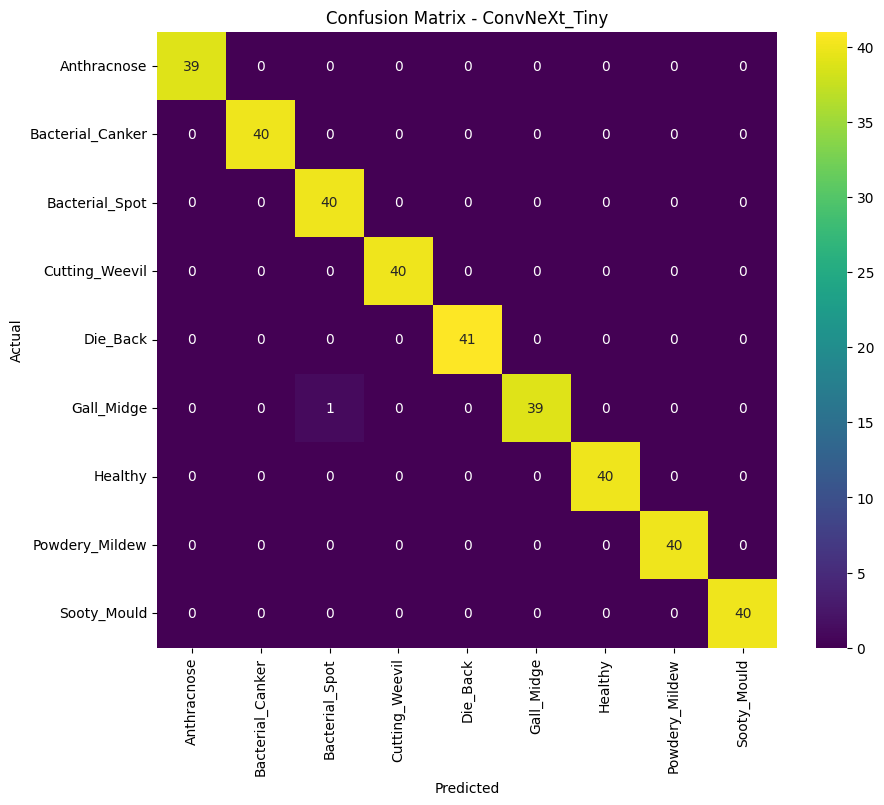

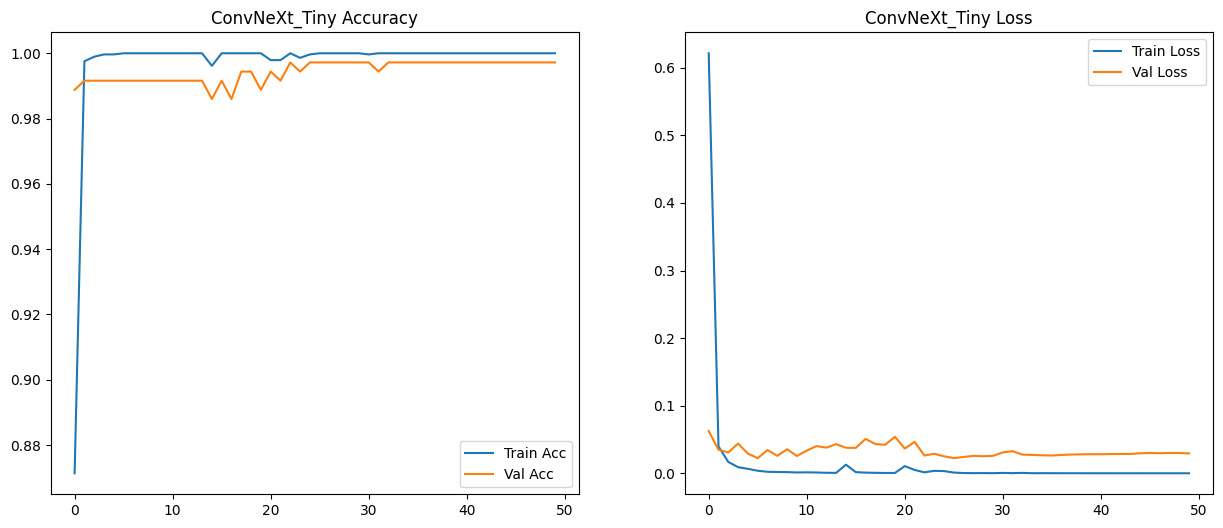

Done ConvNeXt_Tiny: Best Val Acc=0.9972, Test Acc=0.9972


In [20]:
## Huấn luyện TỐI ƯU mô hình: ConvNeXt_Tiny
m_name = 'ConvNeXt_Tiny'
m_res_path = os.path.join(RESULT_PATH, m_name)
os.makedirs(m_res_path, exist_ok=True)

print(f'--- Đang khởi tạo mô hình: {m_name} (Hybrid CNN-Transformer) ---')
model = get_model(m_name, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.05) # AdamW tốt hơn cho ConvNeXt
scaler = torch.cuda.amp.GradScaler()
early_stopper = EarlyStopping(patience=5, verbose=True) # Dừng nếu 8 epoch không giảm loss

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_acc = 0.0

for epoch in range(EPOCHS):
    # --- PHASE: TRAIN ---
    model.train(); tr_loss, tr_correct = 0, 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        tr_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        tr_correct += (preds == labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # --- PHASE: VAL ---
    model.eval(); v_loss, v_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            with torch.cuda.amp.autocast():
                outputs = model(inputs); loss = criterion(outputs, labels)
            v_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            v_correct += (preds == labels).sum().item()
    
    # Lưu History
    epoch_val_acc = v_correct / len(val_set)
    history['train_loss'].append(tr_loss/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['train_acc'].append(tr_correct/len(train_set))
    history['val_acc'].append(epoch_val_acc)
    
    # Lưu mô hình tốt nhất
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), os.path.join(m_res_path, 'best_model.pth'))

# --- ĐÁNH GIÁ VÀ VẼ MA TRẬN NHẦM LẪN ---
print(f'--- Đang đánh giá {m_name} ---')
model.load_state_dict(torch.load(os.path.join(m_res_path, 'best_model.pth')))
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.to(DEVICE))
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# 1. Vẽ Confusion Matrix (Bảng màu hiện đại Viridis)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title(f'Confusion Matrix - {m_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(os.path.join(m_res_path, 'confusion_matrix.png'))
plt.show()

# 2. Tính toán & Lưu Báo cáo phân loại (Sạch sẽ)
acc = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
with open(os.path.join(m_res_path, 'report.json'), 'w') as f:
    json.dump(report, f, indent=4)

# 3. Vẽ đồ thị Loss/Accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(history['train_acc'], label='Train Acc'); axes[0].plot(history['val_acc'], label='Val Acc')
axes[0].set_title(f'{m_name} Accuracy'); axes[0].legend()
axes[1].plot(history['train_loss'], label='Train Loss'); axes[1].plot(history['val_loss'], label='Val Loss')
axes[1].set_title(f'{m_name} Loss'); axes[1].legend()
plt.savefig(os.path.join(m_res_path, 'metrics_curves.png'))
plt.show()

print(f'Done {m_name}: Best Val Acc={best_acc:.4f}, Test Acc={acc:.4f}')
del model; torch.cuda.empty_cache()